In [1]:
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import numpy as np
from bias_correction import BiasCorrection, XBiasCorrection
from base import QuantileMapping
from torch_bias_corrector import LSTM_BiasCorrector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from metric import *

# Read the text file into a DataFrame
# df = pd.read_csv('MATH3133_mv/all_vars.txt', delimiter='\s+')
# df.columns = ['date', 'name', 'lat', 'lon', 'value']

df = pd.read_csv('221212.csv')

# Convert 'dayno' to datetime
df['date'] = pd.to_datetime('1989-12-31') + pd.to_timedelta(df['dayno'], unit='D')

# Split the DataFrame into two halves for training and validation
train_df = df.iloc[:len(df)//2]
validation_df = df.iloc[len(df)//2:]



In [7]:
train_column = 'agg.raw_CCCMA3.1_R1_hist'
gt_column = 'agg.AWAP'

normaliser = StandardScaler(with_mean=False)
train = normaliser.fit_transform(train_df[train_column].values.reshape(-1, 1))
target = normaliser.transform(train_df[gt_column].values.reshape(-1, 1))

valid_input = normaliser.transform(validation_df[train_column].values.reshape(-1, 1))
valid_target = normaliser.transform(validation_df[gt_column].values.reshape(-1, 1))

min_rain = 0.1
scaled_rain = normaliser.transform(np.array([[min_rain]])).item()

model_lstm = LSTM_BiasCorrector(train, target, 
                        [DryDayLoss(scaled_rain), MaximumPrecipLoss(), RainfallVariance(scaled_rain), AverageRainfallLoss(scaled_rain)], 
                        [1/0.05852227, 1/11.19133282, 1/4.78557444, 1/0.56426352])

model = model_lstm
# model = QuantileMapping(train, target)
model.train()



Training the LSTM...
Epoch [100/1000], Loss: 82.3780
Epoch [200/1000], Loss: 53.6714
Early stopping triggered at 279!
Best loss: 38.16269302368164


(3653, 1)
Correlation between corrected and input: 0.9120646978595742


C:\Users\simon\AppData\Local\Temp\ipykernel_25752\695662127.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


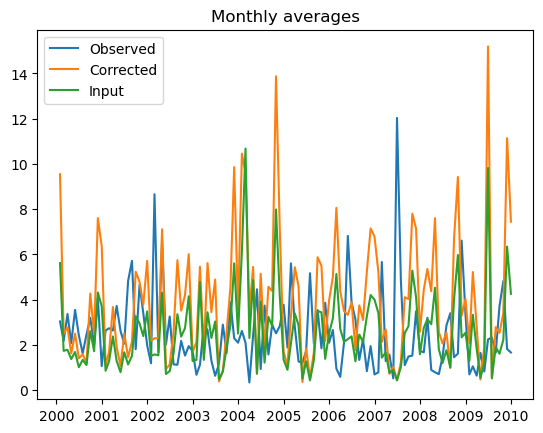

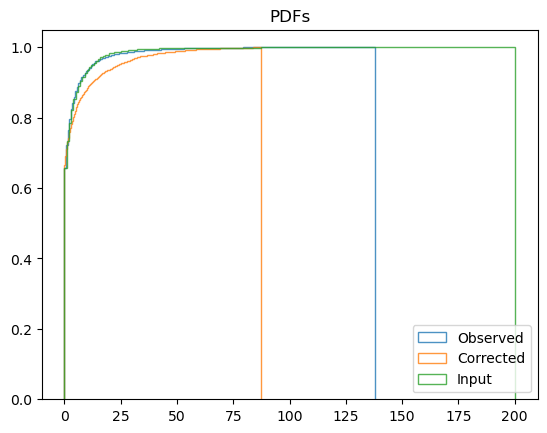

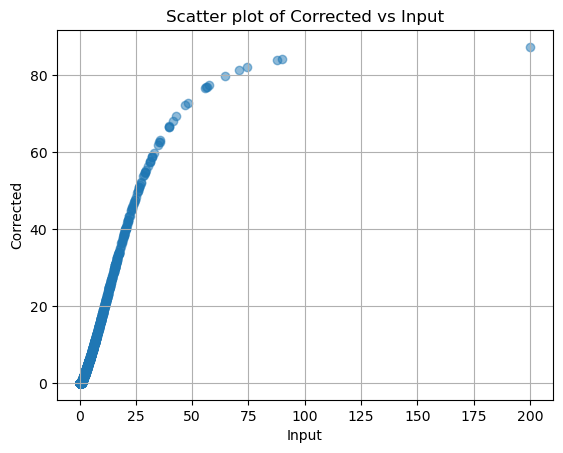

In [8]:
# total_input = np.concatenate([train, valid_input])
# total_target = np.concatenate([target, valid_target])
total_input = np.concatenate([valid_input])
total_target = np.concatenate([valid_target])

pred = model.predict(total_input)

print(pred.shape)

total_input = normaliser.inverse_transform(total_input)
pred = normaliser.inverse_transform(pred)
total_target = normaliser.inverse_transform(total_target)

# Convert arrays to DataFrame for easier manipulation
data = pd.DataFrame({
    'date': validation_df['date'],
    'total_target': total_target.flatten(),
    'pred': pred.flatten(),
    'total_input': total_input.flatten()
})

# Set the date as the index
data.set_index('date', inplace=True)

# Resample to monthly frequency and calculate the mean
monthly_data = data.resample('M').mean()

# Plot the monthly averages
plt.figure()
plt.title('Monthly averages')
plt.plot(monthly_data['total_target'], label='Observed')
plt.plot(monthly_data['pred'], label='Corrected')
plt.plot(monthly_data['total_input'], label='Input')
plt.legend()

plt.figure()
plt.title('CDFs')
plt.hist(data['total_target'], bins=200, alpha=0.8, label='Observed', density=True, cumulative=True, histtype='step')
plt.hist(data['pred'], bins=200, alpha=0.8, label='Corrected', density=True, cumulative=True, histtype='step')
plt.hist(data['total_input'], bins=200, alpha=0.8, label='Input', density=True, cumulative=True, histtype='step')
plt.legend()

# plt.title('Losses')
# fig, ax1 = plt.subplots()

# color = 'tab:blue'
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel(model.losses[0].__class__.__name__, color=color)
# ax1.plot(np.array(model.loss_data)[0], label=model.losses[0].__class__.__name__, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:orange'
# ax2.set_ylabel(model.losses[1].__class__.__name__, color=color)
# ax2.plot(np.array(model.loss_data)[1], label=model.losses[1].__class__.__name__, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()

# fig, ax3 = plt.subplots()

# color = 'tab:green'
# ax3.set_xlabel('Epoch')
# ax3.set_ylabel(model.losses[2].__class__.__name__, color=color)
# ax3.plot(np.array(model.loss_data)[2], label=model.losses[2].__class__.__name__, color=color)
# ax3.tick_params(axis='y', labelcolor=color)

# ax4 = ax3.twinx()
# color = 'tab:red'
# ax4.set_ylabel(model.losses[3].__class__.__name__, color=color)
# ax4.plot(np.array(model.loss_data)[3], label=model.losses[3].__class__.__name__, color=color)
# ax4.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()
# plt.legend()
# plt.show()

# Calculate the correlation between 'pred' and 'total_input'
correlation = data['pred'].corr(data['total_input'])
print(f'Correlation between corrected and input: {correlation}')

# Create a scatter plot to visualize the correlation
plt.figure()
plt.title('Scatter plot of Corrected vs Input')
plt.scatter(data['total_input'], data['pred'], alpha=0.5)
plt.xlabel('Input')
plt.ylabel('Corrected')
plt.grid(True)
plt.show()


In [4]:
# Make a table with the loss evaluated on the validation set
losses = [loss(torch.Tensor(valid_input), torch.Tensor(valid_target)) for loss in model_lstm.losses]
print('Losses on validation set:')
for loss, value in zip([loss.__class__.__name__ for loss in model_lstm.losses], losses):
    print(f'{loss}: {value}')

if isinstance(model, LSTM_BiasCorrector):
    print(model.loss_coeff)
    print(np.array(model.loss_data)[:,0])

Losses on validation set:
DryDayLoss: 4.358704973128624e-05
MaximumPrecipLoss: 101.22196960449219
RainfallVariance: 0.1156153455376625
AverageRainfallLoss: 0.003758038394153118
[17.08751215562896, 0.08935486202437862, 0.20896133004254341, 1.7722216031261422]
[1.00026414e-01 1.00139580e+02            nan            nan]
